# Dimension reduction on raster data

Unsupervised data analytics are powerful tools for data exploration. A common method is the principal component analysis (PCA), which enables to analyze high-dimensional data. PCA is a dimension reduction method that derives common features across multiple dimensions (e.g. different environmental variables) into Principal components (vectors of join variation). This enables to reduce multiple, redundat variables into common latent variables but also enables to analyze common variation.

You are not aware of what a PCA is or is used for then you check these quick summaries:
* https://www.youtube.com/watch?v=HMOI_lkzW08&ab_channel=StatQuestwithJoshStarmer
* https://www.youtube.com/watch?v=Lsue2gEM9D0&ab_channel=StatQuestwithJoshStarmer


With this chapter, we will also add another data product, which is SoilGrids. SoilGrids are global raster products that have been extrapolated with sateöllite data from point observations (place where people actually sampled soil properties). It provides information on various soil properties, including clay or sand content, pH, nitrogen content or soil organic carbon.

With this product, we now have a large suite of geoproducts for our analysis, which is:
* the MODIS reflectance data: https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer
* The VOD (vertical optical depth) data: https://essd.copernicus.org/articles/12/177/2020/essd-12-177-2020.html
* Climate data from WorldClim: https://www.worldclim.org/data/bioclim.html
* Soil information from SoilGrids: https://soilgrids.org/

This session is meant to explore the interrelationship among these products.


## Assignments
* Do a joint PCA with MODIS/VOD/Worldclim/Soil data (SoilGrids in the folder ```data/soil_res/```).
    * load MODIS-based vegetation indices (2-3 different indices) and VOD data, calculate statistical moments (means/standard deviation/max/mean) across the months. Then, merge the statistical moments with the WorldClim data.
    * Tip1: You may have to resample the other datasets to Worldclim:
            ``` resampled_raster = raster_to_resample.rio.reproject_match(target_raster) ```
    * Tip2: Consider to increase the plot size of the PCA to avoid overlapping labels and to ease interpretability.
    * Try to interpet the result. Which variables are dependent and independent from each other. How can you explain this?

* Add biome information to the point data to visualize how biomes are distributed in the PCA space (latent space).
* Try to calculate the PCA based on the entire WorldClim dataset (not subsamples) and visualize the PCA components spatially.
    * Tip1: First flatten the raster data into vectors / an array, then calculate the PCA, transfer the components back to a raster and plot the raster as an RGB map (R = 1st PC, G = 2nd PC, B = 3rd PC)
    * if the size of the dataset is too large, consider to resample the raster to a coarser resolution ```raster.coarsen(....)```
    * Plot the RGB-PCA map next to the biome map (```01_earth_observation_products_inspect.ipynb```) - does the RGB-PCA resemble patterns of the biome map?


## Load packages, etc.

In [21]:
import rioxarray
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA # install via conda/mamba/pip install scikit-learn

In [22]:
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load and preprocess data

In [23]:
files = glob.glob('data/earth_obseration_products/worldclim_res/**/*.tif', recursive=True)
files

['data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_1.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_12.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_13-14.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_15.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_4.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_7.tif']

In [27]:
# open all files 
#rasters = [rioxarray.open_rasterio(rf) for rf in files]
rasters = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf, masked=True) for rf in files}
# coarsen the rasters to ease computional load
#rasters = [raster.coarsen(x=40, y=40).mean() for raster in rasters]

In [29]:
rasters

{'bio_1': <xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
 [1620000 values with dtype=float32]
 Coordinates:
   * band         (band) int32 4B 1
   * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
   * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
     spatial_ref  int32 4B 0
 Attributes:
     AREA_OR_POINT:       Area
     STATISTICS_MAXIMUM:  31.387500762939
     STATISTICS_MEAN:     nan
     STATISTICS_MINIMUM:  -54.770832061768
     STATISTICS_STDDEV:   nan
     scale_factor:        1.0
     add_offset:          0.0,
 'bio_12': <xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
 [1620000 values with dtype=float32]
 Coordinates:
   * band         (band) int32 4B 1
   * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
   * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
     spatial_ref  int32 4B 0
 Attributes:
     AREA_OR_POINT:       Area
     STATISTICS_MAXIM

In [31]:
rasters['bio_1']

<xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
[1620000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  31.387500762939
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -54.770832061768
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0

In [28]:
rasters['bio_12']

<xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
[1620000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  11256
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0

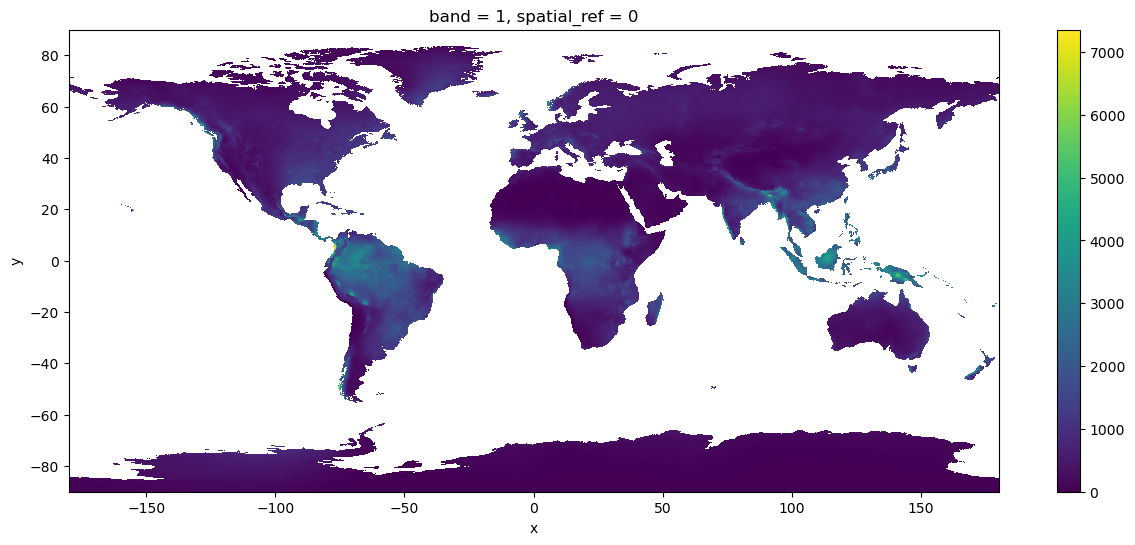

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
rasters['bio_12'].plot()

In [32]:

# Get the first raster
first_raster = rasters[next(iter(rasters))].values.flatten()

# Create an array of indices of non-NA values
#non_na_indices = np.arange(len(first_raster))[(first_raster > -3.400000e+37) & (first_raster < 3.400000e+37)]
non_na_indices = np.isnan(first_raster)
non_na_indices

array([ True,  True,  True, ..., False, False, False])

## Subsample the data (for faster processing)

In [33]:
np.random.seed(0)

# Get the first raster
first_raster = rasters[next(iter(rasters))].values.flatten()

# Create an array of indices of non-NA values
non_na_indices = np.arange(len(first_raster))[np.isfinite(first_raster)]

# Draw random indices from the non-NA indices
index = np.random.choice(non_na_indices, 1000)

# Draw samples using the random indices
samples = pd.DataFrame({name: raster.values.flatten()[index] for name, raster in rasters.items()})

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,24.005407,3175.360107,203.271118,26.787094,29.250107,9.346668
1,-24.455482,525.546692,71.146667,46.494061,656.555908,24.900002
2,-3.585037,702.422241,75.040001,46.836536,1326.684326,45.204445
3,0.287704,482.168884,154.364441,123.969688,1398.889160,48.783112
4,20.987055,431.982208,51.200001,46.795547,613.437561,30.193777


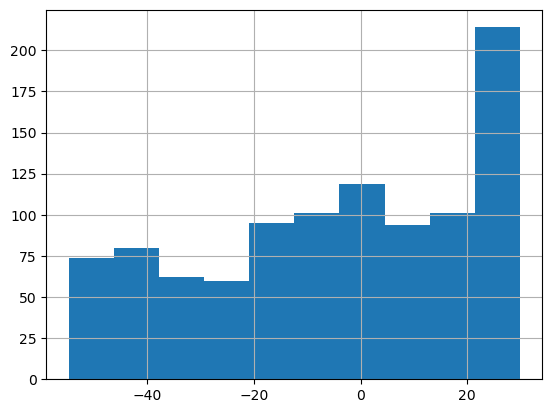

In [35]:
samples['bio_1'].hist()
samples.head()

In [36]:
# scale each column of samples to have mean 0 and variance 1
samples_scaled = samples.copy()
for col in samples_scaled.columns:
    samples_scaled[col] = (samples_scaled[col] - samples_scaled[col].mean()) / samples_scaled[col].std()

In [37]:
samples.head()

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,24.005407,3175.360107,203.271118,26.787094,29.250107,9.346668
1,-24.455482,525.546692,71.146667,46.494061,656.555908,24.900002
2,-3.585037,702.422241,75.040001,46.836536,1326.684326,45.204445
3,0.287704,482.168884,154.364441,123.969688,1398.889160,48.783112
4,20.987055,431.982208,51.200001,46.795547,613.437561,30.193777


In [38]:
samples_scaled.head()

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,1.161899,3.805779,1.501827,-1.070658,-1.788219,-2.007175
1,-0.775699,-0.047380,-0.056591,-0.631699,-0.478224,-0.734767
2,0.058758,0.209819,-0.010669,-0.624070,0.921197,0.926327
3,0.213601,-0.110457,0.924969,1.094017,1.071982,1.219095
4,1.041217,-0.183434,-0.291864,-0.624983,-0.568267,-0.301687


## Apply and inspect the PCA

In [47]:
len(samples_scaled.columns)

6

In [40]:
# calculate a PCA based on the sampled values
pca = PCA(n_components=6)  # lets test with 10 components (max components is the number of columns of the input dataset, but the last components are primarily noise anyway)
pca_result = pca.fit_transform(samples_scaled)

In [41]:
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance)

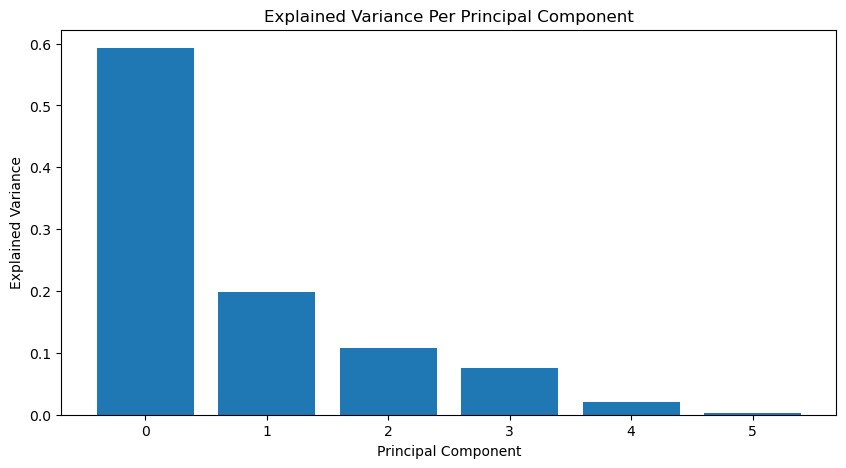

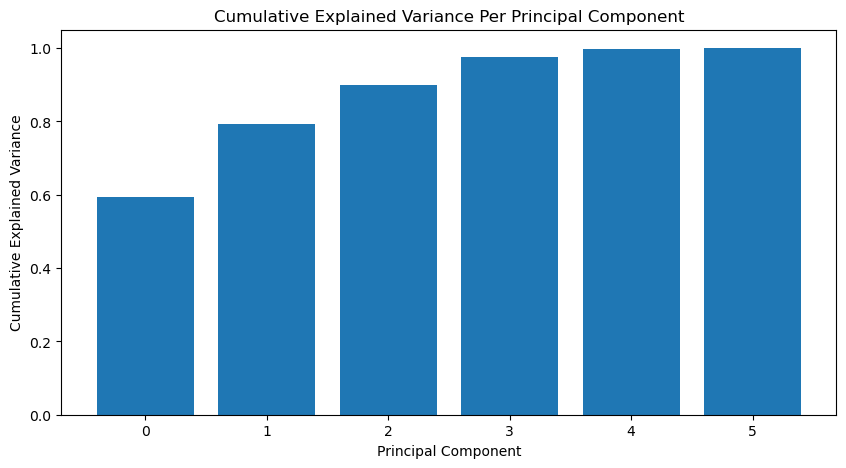

In [42]:
# Create a bar plot for the explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance)), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Per Principal Component')
plt.show()

# Create a bar plot for the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance_cumulative)), explained_variance_cumulative)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Per Principal Component')
plt.show()

In [43]:
print("Explained Variance: ", explained_variance)
print("Cumulative Explained Variance: ", explained_variance_cumulative)

Explained Variance:  [0.59272164 0.19892238 0.10829899 0.07628637 0.0211474  0.00262327]
Cumulative Explained Variance:  [0.59272164 0.79164404 0.89994305 0.9762294  0.9973768  1.0000001 ]


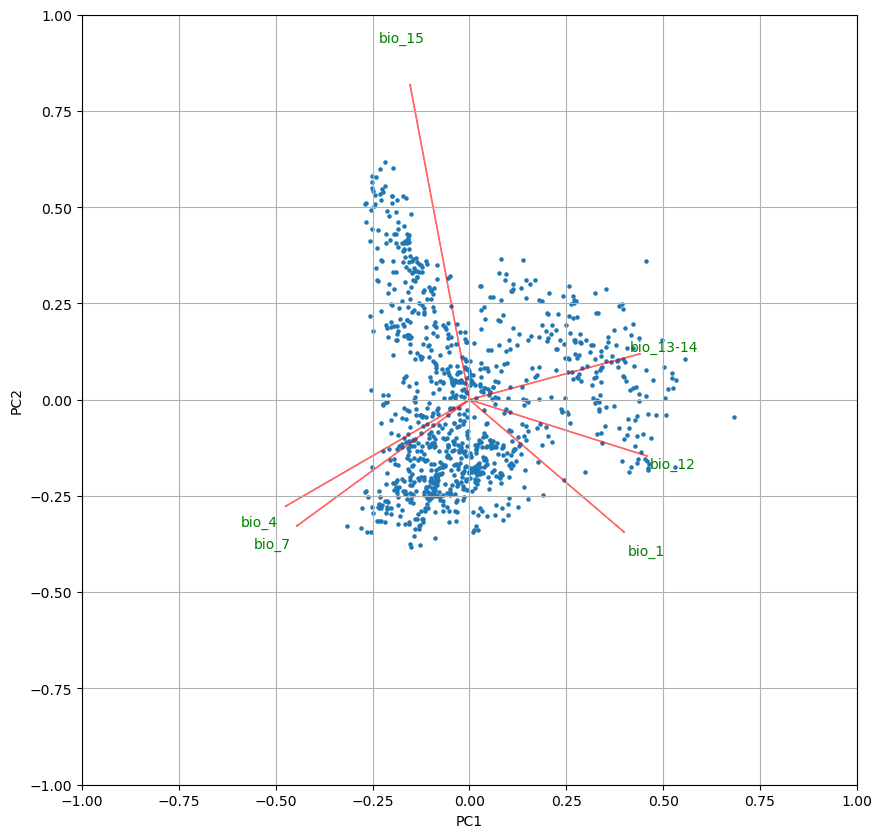

In [48]:
# create an ordination plot of the PCA with arrows indicating the direction of the original variables
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(10, 10))
    plt.scatter(xs * scalex,ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

# apply the biplot function
biplot(pca_result[:,0:2], np.transpose(pca.components_[0:2, :]), labels=samples.columns)

| Variable | Description                                       |
|----------|---------------------------------------------------|
| BIO1     | Annual Mean Temperature                           |
| BIO4     | Temperature Seasonality (standard deviation ×100) |
| BIO7     | Temperature Annual Range (BIO5-BIO6)             |
| BIO11    | Mean Temperature of Coldest Quarter              |
| BIO12    | Annual Precipitation                              |
| BIO13    | Precipitation of Wettest Month                   |
| BIO14    | Precipitation of Driest Month                    |
| BIO15    | Precipitation Seasonality (Coefficient of Variation) |